# **2D-CNN**

In [1]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import matplotlib.pyplot as plt
import os
import soundfile as sf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
import scipy
import scipy.signal
import scipy.fftpack
import librosa
from Extra import WaveGlow_functions
import librosa.display
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.compat.v1.keras.backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
import gc
from Extra import MelFilterBank as mel
from Extra import reconstructWave as rW

2023-11-29 10:51:55.994015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 10:51:57.437124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-29 10:51:57.437251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras

In [2]:
# Set TensorFlow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-11-29 10:51:59.198615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 10:51:59.231035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 10:51:59.231311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


### **Helper functions**

In [3]:
#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(
    x, scipy.fftpack.next_fast_len(len(x)), axis=0)[:len(x)]

In [4]:
def extractHG(data,
              sr,
              windowLength=0.05,
              frameshift=0.01,
              bandpass_min=70,
              bandpass_max=170):
    """
    Window data and extract frequency-band envelope using the hilbert transform
    
    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data, axis=0)
    #Number of windows
    numWindows = int(
        np.floor((data.shape[0] - windowLength * sr) / (frameshift * sr)))
    #Filter High-Gamma Band
    # sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    sos = scipy.signal.iirfilter(
        4, [bandpass_min / (sr / 2), bandpass_max / (sr / 2)],
        btype='bandpass',
        output='sos')
    data = scipy.signal.sosfiltfilt(sos, data, axis=0)
    #Attenuate first harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows, data.shape[1]))
    for win in range(numWindows):
        start = int(np.floor((win * frameshift) * sr))
        stop = int(np.floor(start + windowLength * sr))
        feat[win, :] = np.mean(data[start:stop, :], axis=0)
    return feat

In [5]:
def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors
    
    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked = np.zeros((features.shape[0] - (2 * modelOrder * stepSize),
                            (2 * modelOrder + 1) * features.shape[1]))
    for fNum, i in enumerate(
            range(modelOrder * stepSize,
                  features.shape[0] - modelOrder * stepSize)):
        ef = features[i - modelOrder * stepSize:i + modelOrder * stepSize +
                      1:stepSize, :]
        featStacked[
            fNum, :] = ef.flatten()  #Add 'F' if stacked the same as matlab
    return featStacked

In [6]:
# WaveGlow / Tacotron2 / STFT parameters for audio data
# samplingFrequency = 16000
samplingFrequency = 22050
#samplingFrequency_EEG = 512 #sub 07
winL_EEG =  ( 0.05)
# frameshift_EEG = 0.01 # 10 ms
frameshift_EEG = 0.01  # 10 ms
frameshift_speech = 220  # 10ms
# modelOrder_EEG = 1
# modelOrder_EEG = 2
modelOrder_EEG = 4
# modelOrder_EEG = 10
stepSize_EEG = 5

In [7]:
stft = WaveGlow_functions.TacotronSTFT(filter_length=1024,
                                       hop_length=frameshift_speech,
                                       win_length=1024,
                                       n_mel_channels=80,
                                       sampling_rate=samplingFrequency,
                                       mel_fmin=0,
                                       mel_fmax=8000)

/environment/notebooks/speech2brain2speech/Extra/WaveGlow_functions.py:136: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/environment/notebooks/speech2brain2speech/Extra/WaveGlow_functions.py:222: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


### **Load Data**

In [8]:
import librosa
import soundfile as sf

# Load the original audio file
y, sr = librosa.load('data/stimuli/6min.wav', sr=None)  # Load with original sampling rate

print("Sampling rate before:", sr, "Hz")
# Resample to 22050 Hz
y_22050 = librosa.resample(y, orig_sr=sr, target_sr=22050)

# Save the resampled audio to a new file
sf.write('resampled_audio_22050Hz.wav', y_22050, 22050)

# Use the resampled file in your processing pipeline
wavfile = 'resampled_audio_22050Hz.wav'

Sampling rate before: 48000 Hz


In [9]:
# Load the resampled audio file
y, sr = librosa.load('resampled_audio_22050Hz.wav', sr=22050)

# Shift the audio by 150 ms
shift_ms = 150  # milliseconds
shift_samples = int(sr * (shift_ms / 1000.0))  # Convert milliseconds to samples
shifted_audio = np.pad(y, (shift_samples, 0), mode='constant', constant_values=(0, 0))

# Save the shifted audio to a new file
sf.write('shifted_audio_22050Hz.wav', shifted_audio, sr)

# Now you can compute the mel-spectrogram of the shifted audio
wavfile = 'shifted_audio_22050Hz.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
mel_data_nonrot = mel_data
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))


# Print shapes and durations
print("Original audio duration (seconds):", len(y) / sr)
print("Shifted audio duration (seconds):", len(shifted_audio) / sr)

Original audio duration (seconds): 390.5707029478458
Shifted audio duration (seconds): 390.72068027210884


In [10]:
#Load Subjects
bids_dir = 'data'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
print(subjects)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63']


In [11]:
#Choose subjects
subject = '13'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

In [12]:
#load subject's channels
channels_path = mne_bids.BIDSPath(subject=subject,
                                  session=session,
                                  suffix='channels',
                                  extension='tsv',
                                  datatype=datatype,
                                  task=task,
                                  acquisition=acquisition,
                                  root=bids_dir)

/tmp/ipykernel_15920/1587233290.py:2: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


In [13]:
channels = pd.read_csv(str(channels_path.match()[0]),
                       sep='\t',
                       header=0,
                       index_col=None)
#print(channels)

In [14]:
#set channel types
data_path = mne_bids.BIDSPath(subject=subject,
                              session=session,
                              suffix='ieeg',
                              extension='vhdr',
                              datatype=datatype,
                              task=task,
                              acquisition=acquisition,
                              root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]),
                                  scale=1.0,
                                  preload=False,
                                  verbose=True)
raw.set_channel_types({
    ch_name:
    str(x).lower() if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
    for ch_name, x in zip(raw.ch_names, channels['type'].values)
})
raw.drop_channels([
    raw.ch_names[i] for i, j in enumerate(raw.get_channel_types())
    if j == 'misc'
])

/tmp/ipykernel_15920/3662225017.py:2: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from data/sub-13/ses-iemu/ieeg/sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_15920/3662225017.py:14: RuntimeWarning: The unit for channel(s) ECG1, ECG2, MKR1+, MKR2+, abdo+, thor+ has changed from V to NA.
  raw.set_channel_types({


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 96 x 201686 (393.9 s), ~99 kB, data not loaded>

### Discard Bad Channels

In [15]:
#bad channels
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG']))
                                & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~97 kB, data not loaded>

### Load Raw Data

In [16]:
raw.load_data()

Reading 0 ... 201685  =      0.000 ...   393.916 secs...


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~144.7 MB, data loaded>

In [17]:
n_eeg_channels = int(raw.info['nchan'])  # for subject 01
print('n_eeg_channels', n_eeg_channels)
# raise

n_eeg_channels 94


### Apply notch filter to remove line noise

In [18]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.4s finished


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~144.7 MB, data loaded>

raw.plot()
plt.show()

### Apply common average reference to remove common noise and trends

In [19]:
#CAR
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


In [20]:
gamma = raw_car.copy().filter(60,
                              120).apply_hilbert(envelope=True).get_data()  #.T
print('raw_car.shape:', raw_car._data.shape, 'gamma shape: ', gamma.shape)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 113 samples (0.221 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.7s finished


raw_car.shape: (94, 201686) gamma shape:  (94, 201686)


#Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options


gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

### Read annotation with event markers

In [21]:
custom_mapping = {
    'Stimulus/music': 2,
    'Stimulus/speech': 1,
    'Stimulus/end task': 5
}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car,
                                               event_id=custom_mapping,
                                               use_rounding=False)

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


Using matplotlib as 2D backend.


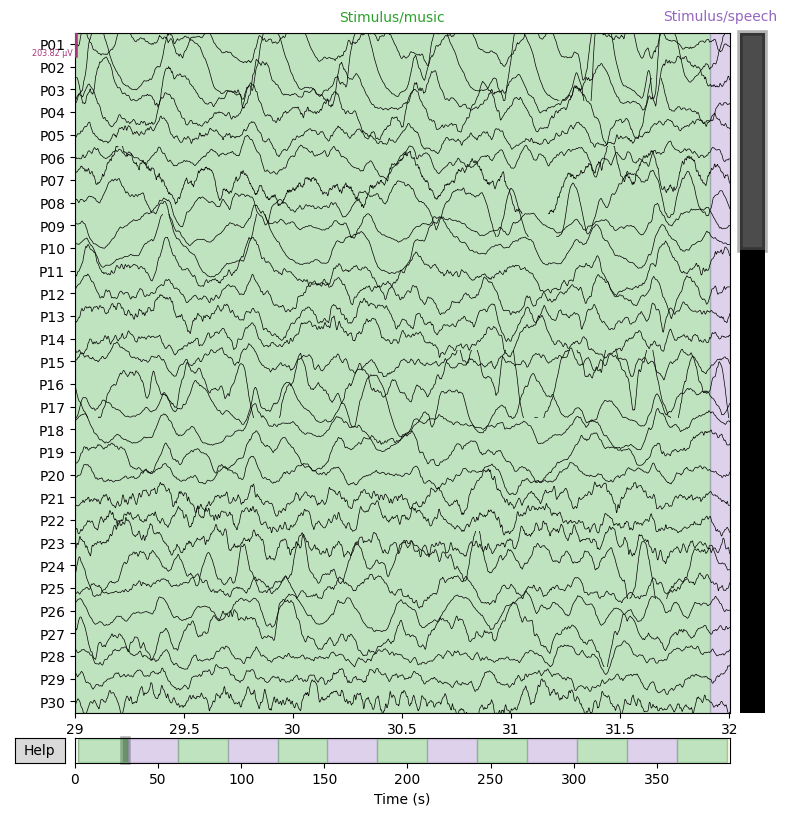

In [22]:
#plotting
raw_car.plot(n_channels=30, scalings='auto', duration=3, start=29)
plt.show()

In [23]:
# assume gamma is a 2D array
np.savetxt("gamma.tsv", gamma, delimiter="\t")

n_melspec = 80
#get EEG SR
samplingFrequency_EEG = raw_car.info['sfreq']

### Crop to keep only the segments while wathcing the stimuli ( 6.5 min long movie)

In [24]:
eeg=raw_car.get_data()


#create a copy taht we crop
raw_car_cut = raw_car.get_data()
print(raw_car_cut.shape)
#(n_channels, n_times)

(94, 201686)


In [25]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

raw_car_cut = np.empty((n_eeg_channels, 0))
mel_data_cut = np.empty((0, n_melspec))

# for i in range(6):
for i in range(6):
    start_time = events[2 * i + 1, 0] / raw_car.info['sfreq']
    end_time = events[2 * i + 2, 0] / raw_car.info['sfreq']
    start_idx, end_idx = raw_car.time_as_index([start_time, end_time])
    print(i, 'iEEG index', start_idx, end_idx, end_idx - start_idx)
    n_frames_per_sec = int(1 / frameshift_EEG)
    print(i, 'melspec index', (2 * i + 1) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec -
          (2 * i + 1) * 30 * n_frames_per_sec)
    # raw_car_cut1 = raw_car._data[:, start_idx:end_idx]
    raw_car_cut1 = eeg[:, start_idx:end_idx]
    raw_car_cut = np.append(raw_car_cut, raw_car_cut1, axis=1)
    mel_data_cut1 = mel_data[(2 * i + 1) * 30 * n_frames_per_sec:(2 * i + 2) *
                             30 * n_frames_per_sec]
    mel_data_cut = np.append(mel_data_cut, mel_data_cut1, axis=0)
# raise
mel_data = mel_data_cut

print('after cut: ', raw_car_cut.shape, mel_data.shape)
# raise
#praat

#get EEG SR
samplingFrequency_EEG = raw_car.info['sfreq']

# Calculate the length of the signal
length = raw_car_cut.shape[1] / samplingFrequency_EEG
print("The length of the EEG signal is", length, "s")
print(samplingFrequency_EEG)

before cut:  (94, 201686) (39161, 80)
0 iEEG index 16337 31698 15361
0 melspec index 3000 6000 3000
1 iEEG index 47062 62425 15363
1 melspec index 9000 12000 3000
2 iEEG index 77788 93145 15357
2 melspec index 15000 18000 3000
3 iEEG index 108506 123868 15362
3 melspec index 21000 24000 3000
4 iEEG index 139230 154594 15364
4 melspec index 27000 30000 3000
5 iEEG index 169952 185312 15360
5 melspec index 33000 36000 3000
after cut:  (94, 92167) (18000, 80)
The length of the EEG signal is 180.013671875 s
512.0


### Extract features

In [26]:
#Extract HG features
print('calculating Hilbert...', raw_car_cut.shape)
# eeg_fft = np.empty((n_max_frames, n_freq_bands, n_eeg_channels * (2 * modelOrder_EEG + 1) ))
# feat_Hilbert_1 = extractHG(raw_car_cut,samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
feat_Hilbert_1 = extractHG(np.rot90(raw_car_cut),
                           samplingFrequency_EEG,
                           windowLength=winL_EEG,
                           frameshift=frameshift_EEG,
                           bandpass_min=1,
                           bandpass_max=120)
# feat_Hilbert_2 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=51, bandpass_max=100)
# feat_Hilbert_3 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=101, bandpass_max=150)
# feat_Hilbert_4 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=151, bandpass_max=200)

calculating Hilbert... (94, 92167)


In [27]:
#Stack features
feat_Hilbert_1 = stackFeatures(feat_Hilbert_1,
                               modelOrder=modelOrder_EEG,
                               stepSize=stepSize_EEG)

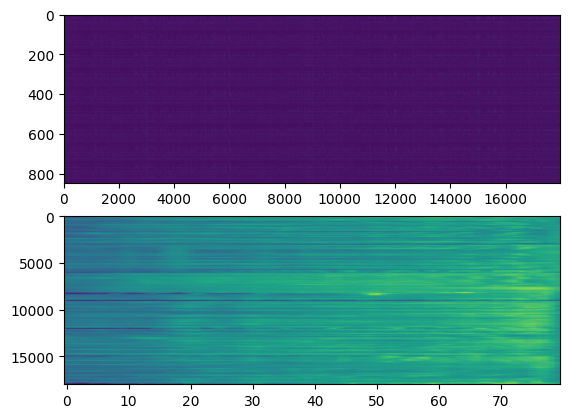

In [28]:
plt.subplot(211)
plt.imshow(np.rot90(feat_Hilbert_1), aspect='auto')

plt.subplot(212)
plt.imshow(np.rot90(mel_data).T, aspect='auto')
plt.show()

eeg = feat_Hilbert_1

In [29]:
min_len = np.min((len(eeg), len(mel_data)))
eeg = eeg[0:min_len]
mel_data = mel_data[0:min_len]

In [30]:
print('mel & iEEG: ', mel_data.shape, feat_Hilbert_1.shape)

mel & iEEG:  (17956, 80) (17956, 846)


In [31]:
train_index = np.arange(0, int(0.8 * eeg.shape[0]))
test_index = np.arange(int(0.8 * eeg.shape[0]), eeg.shape[0])

In [32]:
# train-validation-test split
eeg_train = eeg[0:int(len(eeg) * 0.8)]
eeg_valid = eeg[int(len(eeg) * 0.8):int(len(eeg) * 0.9)]
eeg_test = eeg[int(len(eeg) * 0.9):]

In [33]:
melspec_train = mel_data[0:int(len(mel_data) * 0.8)]
melspec_valid = mel_data[int(len(mel_data) * 0.8):int(len(mel_data) * 0.9)]
melspec_test = mel_data[int(len(mel_data) * 0.9):]

In [34]:
# scale input to [0-1]
eeg_scaler = MinMaxScaler()
# eeg_scaler = StandardScaler(with_mean=True, with_std=True)
eeg_train_scaled = eeg_scaler.fit_transform(eeg_train)
eeg_valid_scaled = eeg_scaler.transform(eeg_valid)
eeg_test_scaled = eeg_scaler.transform(eeg_test)

In [35]:
# scale outpit mel-spectrogram data to zero mean, unit variances
melspec_scaler = StandardScaler(with_mean=True, with_std=True)
melspec_train_scaled = melspec_scaler.fit_transform(melspec_train)
melspec_valid_scaled = melspec_scaler.transform(melspec_valid)
melspec_test_scaled = melspec_scaler.transform(melspec_test)

# **2D CNN**

In [36]:
def strided_app(a,
                L,
                S,
                verbose=None):  # Window len = L, Stride len/stepsize = S
    shape = a.shape[1:]
    nrows = ((a.shape[0] - L) // S) + 1
    strides = a.strides
    #print(shape, strides)
    if verbose:
        print("strides:", strides)
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, L) + shape,
                                           strides=(S * strides[0], ) +
                                           strides)

In [37]:
method = '2D-CNN'
result_path = os.path.join(os.getcwd(), f"results_{method}")
winLength = 0.05
frameshift = 0.01
audiosr = 16000

spectrogram = mel_data
data = eeg
pt = subject

In [38]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [39]:
    # Create a train and test split from data, test is 20% of the data
    train_index = np.arange(0, int(0.8 * data.shape[0]))
    test_index = np.arange(int(0.8 * data.shape[0]), data.shape[0])

    # Initialize an empty spectrogram to save the reconstruction to
    rec_spec = np.zeros(spectrogram.shape)

    # Z-Normalize with mean and std from the training data
    mu = np.mean(data[train_index, :], axis=0)
    std = np.std(data[train_index, :], axis=0)
    trainData = (data[train_index, :] - mu) / std
    testData = (data[test_index, :] - mu) / std

    # Z-Normalize with mean and std from the training data -- output
    mu = np.mean(spectrogram[train_index, :], axis=0)
    std = np.std(spectrogram[train_index, :], axis=0)
    trainSpectrogram = (spectrogram[train_index, :] - mu) / std
    testSpectrogram = (spectrogram[test_index, :] - mu) / std

    print('Input shape: ', trainData.shape)
    print('Input shape: ', testData.shape)
        
    # Find the right shape for the input, as it should be 3D, like 1143 is 9*127
    new_shape = int(trainData.shape[1] / 9)

    # reshape input from 1143 to 9*127
    trainData = trainData.reshape(-1, 9, new_shape)
    testData = testData.reshape(-1, 9, new_shape)
    print('Input shape: ', trainData.shape)

    sts = 6
    window_size = sts * 4 + 1
    n_to_skip = np.floor(window_size // 2).astype(np.int64)

    print('Input shape: ', trainData.shape)

    #conversion to 3D blocks
    trainData = strided_app(trainData, window_size, 1)
    trainSpectrogram = trainSpectrogram[n_to_skip:(trainSpectrogram.shape[0] - n_to_skip)]

    testData = strided_app(testData, window_size, 1)
    testSpectrogram = testSpectrogram[n_to_skip:(testSpectrogram.shape[0] - n_to_skip)]

    print('Input shape: ', trainData.shape)
    print('Input/validation shape: ', testData.shape)
    print('Output shape: ', trainSpectrogram.shape)

Input shape:  (14364, 846)
Input shape:  (3592, 846)
Input shape:  (14364, 9, 94)
Input shape:  (14364, 9, 94)
Input shape:  (14340, 25, 9, 94)
Input/validation shape:  (3568, 25, 9, 94)
Output shape:  (14340, 80)


In [ ]:
    model = Sequential()
    model.add(InputLayer(input_shape=trainData.shape[1:]))
    model.add(Conv2D(filters=10,
                     kernel_size=(13, 13),
                     strides=(sts, 2),
                     activation=tensorflow.nn.swish,
                     padding="same",
                     kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001),
                     input_shape=trainData.shape[1:]))

    model.add(Dropout(0.2))
    model.add(Conv2D(filters=40, kernel_size=(13, 13), strides=(2, 2), activation=tensorflow.nn.swish,
                     padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=40, kernel_size=(13, 13), strides=(2, 2), activation=tensorflow.nn.swish,
                     padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     kernel_regularizer=regularizers.l1(0.00001)))
    model.add(Dropout(0.2))
   # model.add(MaxPooling2D(pool_size=(2, 2)))
  #  model.add(Conv2D(filters=200, kernel_size=(13, 13), strides=(2, 2), activation=tensorflow.nn.swish,
 #                    padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
 #                    kernel_regularizer=regularizers.l1(0.00001)))
  #  model.add(Dropout(0.1))
    #model.add(Conv3D(filters=100, kernel_size=(1, 13, 13), strides=(1, 1, 1), activation=tensorflow.nn.swish,
                     # padding="same", kernel_initializer=keras.initializers.he_uniform(seed=None),
                     # kernel_regularizer=regularizers.l1(0.00001)))
    #model.add(Dropout(0.2))
    #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Flatten())
    model.add(
        Dense(100, activation=tensorflow.nn.swish, kernel_initializer=keras.initializers.he_uniform(seed=None),
              bias_initializer=keras.initializers.he_uniform(seed=None),
              kernel_regularizer=regularizers.l1(0.000005)))
    model.add(Dropout(0.1))
    model.add(Dense(trainSpectrogram.shape[1], activation='linear'))

    plot_model(model, to_file=f"model_{method}.png", show_shapes=True, show_layer_names=True)

    model.compile(
            loss='mean_squared_error',
            metrics=['mean_squared_error'],
            optimizer='adam')
    earlystopper = EarlyStopping(monitor='val_mean_squared_error', min_delta=0.001, patience=3, verbose=1,
                                 mode='auto')
    lrr = ReduceLROnPlateau(monitor='val_mean_squared_error', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

    print(model.summary())

    if not (os.path.isdir('models/')):
        os.mkdir('models/')

    # early stopping to avoid over-training
    model_name = 'models/iEEG_to_melspec_2D-CNN_sp-' + pt

    # csapot: temporarily disabled
    checkp = ModelCheckpoint(
        model_name +
        '_weights_best.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min')

    # Run training
    history = model.fit(trainData, trainSpectrogram,
                        epochs=100, batch_size=32, shuffle=False, verbose=1,
                        callbacks=[earlystopper, checkp, lrr],
                        validation_data=(testData, testSpectrogram),
                        )


    # load back best weights
    model.load_weights(model_name + '_weights_best.h5')

    rec_spec = model.predict(testData)

    # inverse transform
    # testSpectrogram=(spectrogram[test,:]-mu)/std
    rec_spec = rec_spec * std + mu

    print('start saving wav')

    # Save reconstructed spectrogram
    os.makedirs(os.path.join(result_path), exist_ok=True)
    np.save(os.path.join(result_path, f'{pt}_predicted_spec.npy'), rec_spec)


    # remove model file
    os.remove(model_name + '_weights_best.h5')
    del model
    # Run garbage collection
    gc.collect()
    
    

2023-11-29 10:52:42.209746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 10:52:42.212915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 10:52:42.213367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 10:52:42.213969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 10)          158870    
                                                                 
 dropout (Dropout)           (None, 5, 5, 10)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 40)          67640     
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 40)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 40)          270440    
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 40)          0         
                                                                 
 flatten (Flatten)           (None, 160)               0

2023-11-29 10:52:46.329714: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1213164000 exceeds 10% of free system memory.
2023-11-29 10:52:48.298017: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1213164000 exceeds 10% of free system memory.


Epoch 1/100


2023-11-29 10:52:50.767731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [ ]:
best_val_mse = min(history.history['val_mean_squared_error'])

fig, axs = plt.subplots(2, 1, figsize=(10, 5))

axs[0].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')

axs[1].imshow(np.rot90(rec_spec[0:1000]), aspect='auto')
axs[1].set_title('2D-CNN')

plt.subplots_adjust(hspace=0.4)
plt.suptitle('2D-CNN results for patient ' + subject + ' ' + f'Best validation MSE: {best_val_mse:.4f}')
plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()

### Audio synth

In [ ]:
#give SR
samplingFrequency = 512
# Convert mel spectrogram to audio using Griffin-Lim algorithm
audio = librosa.feature.inverse.mel_to_audio(rec_spec, sr=samplingFrequency)

# Save the audio to a WAV file
output_file = subject+'predicted_audio_2dcnn.wav'
sf.write(output_file, audio, samplingFrequency)